# Creating the Model Grid

## Import Modules

In [2]:
import numpy as np
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

## Project's Grid

The grid for Jonathan's model will be of the entire planet, with a grid spacing of 0.5° covering 720 columns and 360 rows.

The vertical space is discretized into 50 levels. (Forget et al., 2015) It follows the standard **ECCO Version 4/5** configuration (llc90), designed to resolve the mixed layer with 10m spacing while extending to 6000m depth.

References:

* Forget, G., et al. (2015). "ECCO version 4: an integrated framework for non-linear inverse modeling and global ocean state estimation." *Geoscientific Model Development*, 8, 3071–3104. [doi:10.5194/gmd-8-3071-2015](https://doi.org/10.5194/gmd-8-3071-2015)
* ECCO Consortium, Fukumori, I., Wang, O., Fenty, I., Forget, G., Heimbach, P., & Ponte, R. M. (2020). *ECCO Central Estimate (Version 4 Release 4)*. [https://catalog.data.gov/dataset/ecco-geometry-parameters-for-the-lat-lon-cap-90-llc90-native-model-grid-version-4-release-](https://catalog.data.gov/dataset/ecco-geometry-parameters-for-the-lat-lon-cap-90-llc90-native-model-grid-version-4-release-)
* [MITgcm/verification_other/global_oce_llc90/input/data](https://github.com/MITgcm/verification_other/blob/master/global_oce_llc90/input/data)

In the data file for the model, the following parameters will be specified in the `PARM04` namelist within the `data` file:

```fortran
 &PARM04
 usingSphericalPolarGrid=.TRUE.,
 xgOrigin=-180,
 ygOrigin=-90,
 dxSpacing=0.5,
 dySpacing=0.5,
# Vertical Grid: Standard ECCO 50-levels (Forget et al., 2015)
 delR = 10.00,  10.00,  10.00,  10.00,  10.00,
        10.00,  10.00,  10.01,  10.03,  10.11,
        10.32,  10.80,  11.76,  13.42,  16.04,
        19.82,  24.85,  31.10,  38.42,  46.50,
        55.00,  63.50,  71.58,  78.90,  85.15,
        90.18,  93.96,  96.58,  98.25,  99.25,
       100.01, 101.33, 104.56, 111.33, 122.83,
       139.09, 158.94, 180.83, 203.55, 226.50,
       249.50, 272.50, 295.50, 318.50, 341.50,
       364.50, 387.50, 410.50, 433.50, 456.50,
 &
```

For this notebook, the parameters are defined as follows:

In [3]:
# Horizontal Grid Parameters
DEL_X = 0.5
DEL_Y = 0.5
XG_ORIGIN = -180
YG_ORIGIN = -90
N_COLS = 720
N_ROWS = 360

# Vertical Grid Parameters
DEL_R = np.array(
    [
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.01,
        10.03,
        10.11,
        10.32,
        10.80,
        11.76,
        13.42,
        16.04,
        19.82,
        24.85,
        31.10,
        38.42,
        46.50,
        55.00,
        63.50,
        71.58,
        78.90,
        85.15,
        90.18,
        93.96,
        96.58,
        98.25,
        99.25,
        100.01,
        101.33,
        104.56,
        111.33,
        122.83,
        139.09,
        158.94,
        180.83,
        203.55,
        226.50,
        249.50,
        272.50,
        295.50,
        318.50,
        341.50,
        364.50,
        387.50,
        410.50,
        433.50,
        456.50,
    ]
)

## Grid Generation Strategy: Why Edges First?

We use an **Edge-based generation** method (`np.linspace`) rather than calculating centers directly (`np.arange`).

`np.arange` is susceptible to floating-point precision errors.
If the accumulated step value drifts slightly (e.g., `179.99999` instead of `180.0`),
the final grid cell may be silently dropped,
altering the model dimensions.

We define the **$N+1$ physical edges** first.
This guarantees the domain boundaries are exact (e.g., $-180^{\circ}$ to $+180^{\circ}$).

Cell centers are derived as the robust average of these edges:

$$
X_{center} = \frac{X_{edge}[i] + X_{edge}[i+1]}{2}
$$

In [4]:
# Horizontal Grid Edges
x_edges = np.linspace(XG_ORIGIN, XG_ORIGIN + N_COLS * DEL_X, N_COLS + 1)
y_edges = np.linspace(YG_ORIGIN, YG_ORIGIN + N_ROWS * DEL_Y, N_ROWS + 1)

# Calculate Centers
xc = (x_edges[:-1] + x_edges[1:]) / 2
yc = (y_edges[:-1] + y_edges[1:]) / 2
xc_mg, yc_mg = np.meshgrid(xc, yc)

# Vertical Grid
# Calculate depth faces
depth_faces = np.concatenate(([0], np.cumsum(DEL_R)))

# Calculate depth centers
depth_centers = (depth_faces[:-1] + depth_faces[1:]) / 2

print(f"Grid Shapes: XC {xc_mg.shape}, YC {yc_mg.shape}, Depth {depth_centers.shape}")

Grid Shapes: XC (360, 720), YC (360, 720), Depth (50,)


## Visualizing the Grid

The grids above can be visualized as follows:

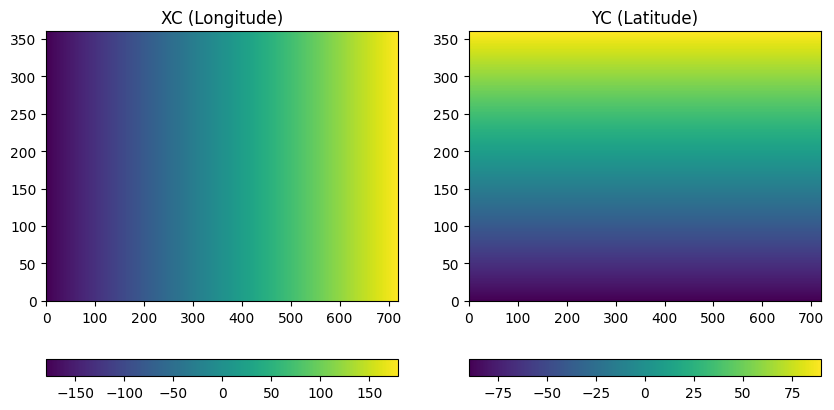

In [5]:
# make a plot of XC and YC
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
C = plt.pcolormesh(xc_mg)
plt.colorbar(C, orientation="horizontal")
plt.title("XC (Longitude)")

plt.subplot(1, 2, 2)
C = plt.pcolormesh(yc_mg)
plt.colorbar(C, orientation="horizontal")
plt.title("YC (Latitude)")

plt.show()

## Visualizing the Grid on a Map with Cartopy

To get a sense of where the model is located on the globe, cartopy can be be used to plot the domain on the globe:

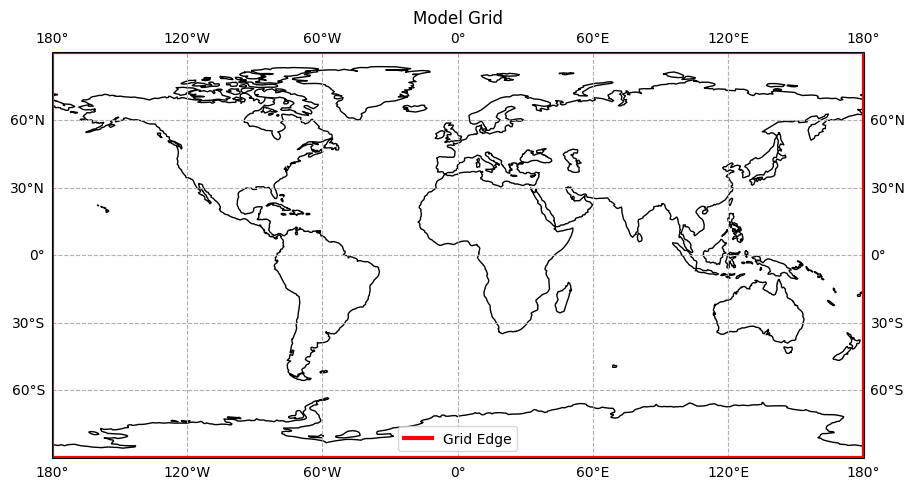

In [6]:
plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True, linestyle="--")

ax.plot(
    [-180, -180],
    [-90, 90],
    "r-",
    linewidth=3,
    transform=ccrs.PlateCarree(),
    label="Grid Edge",
)
ax.plot([180, 180], [-90, 90], "r-", linewidth=3, transform=ccrs.PlateCarree())
ax.plot([-180, 180], [-90, -90], "r-", linewidth=3, transform=ccrs.PlateCarree())
ax.plot([-180, 180], [90, 90], "r-", linewidth=3, transform=ccrs.PlateCarree())

ax.set_title("Model Grid")
ax.legend(loc="lower center")
ax.set_global()

plt.tight_layout()
plt.show()

## Visualizing the Grid Spacing

The model grid is defined in terms of units in longitude and latitude although it is useful to quantify the grid spacing in terms of more familiar units, such as meters. The following `great_circle_distance` function can be used to quantify this distance:

In [7]:
def great_circle_distance(lon_ref, lat_ref, lon, lat):
    """
    Vectorized Haversine formula to calculate great circle distance
    between arrays of points. Inputs can be 2D arrays.
    """
    earth_radius = 6371000.0
    lon_ref_radians, lat_ref_radians = np.radians(lon_ref), np.radians(lat_ref)
    lon_radians, lat_radians = np.radians(lon), np.radians(lat)
    lat_diff = lat_radians - lat_ref_radians
    lon_diff = lon_radians - lon_ref_radians
    d = (
        np.sin(lat_diff / 2.0) ** 2
        + np.cos(lat_ref_radians) * np.cos(lat_radians) * np.sin(lon_diff / 2.0) ** 2
    )
    h = 2 * np.arcsin(np.sqrt(d))
    return earth_radius * h

Then, loop through the points to generate inter-point distances in the horizontal (`dXC`) and vertical (`dYC`) directions:

In [8]:
D_XC = great_circle_distance(xc_mg[:, :-1], yc_mg[:, :-1], xc_mg[:, 1:], yc_mg[:, 1:])

D_YC = great_circle_distance(xc_mg[:-1, :], yc_mg[:-1, :], xc_mg[1:, :], yc_mg[1:, :])

Finally, make a plot of the inter-point distances:

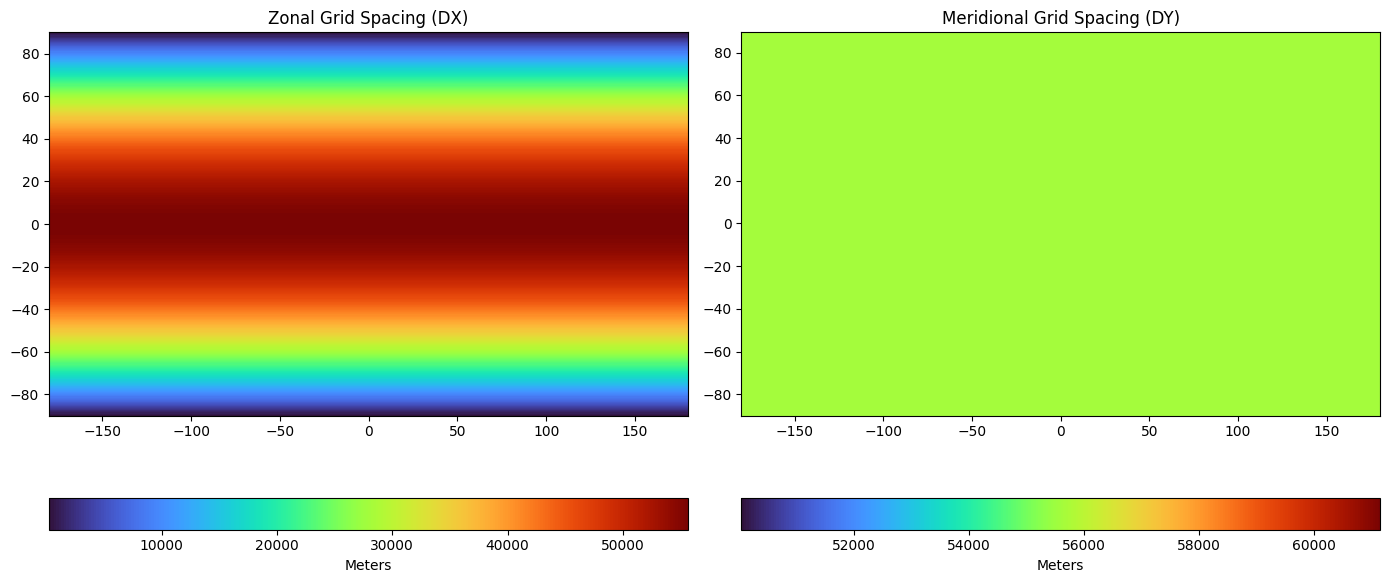

In [9]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
C1 = plt.pcolormesh(xc_mg[:, :-1], yc_mg[:, :-1], D_XC, cmap="turbo")
plt.colorbar(C1, orientation="horizontal", label="Meters")
plt.title("Zonal Grid Spacing (DX)")

plt.subplot(1, 2, 2)
C2 = plt.pcolormesh(xc_mg[:-1, :], yc_mg[:-1, :], D_YC.round(3), cmap="turbo")
plt.colorbar(C2, orientation="horizontal", label="Meters")
plt.title("Meridional Grid Spacing (DY)")

plt.tight_layout()
plt.show()